<a href="https://colab.research.google.com/github/Pathairush/ShopeeCodeLeague/blob/main/multi_channel_contacts_problem_quickversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem : Multi-Channel Contacts Problem

Task
1.   For each ticket, identify all contacts from each user if they have the same contact information.
2.   For the purpose of this question, assume that all contacts from the same Phone Number / Email
are the same user.

Basic concept

1.   Each Order ID represents a transaction in Shopee.
2.   Each Id represents the Ticket Id made to Shopee Customer Service.
3.   All Phone Numbers are stored without the country code and the country code can be ignored.
4.   Contacts represent the number of times a user reached out to us in that particular ticket (Email,
Call, Livechat etc.)
5.   If a value is NA means that the system or agent has no record of that value.

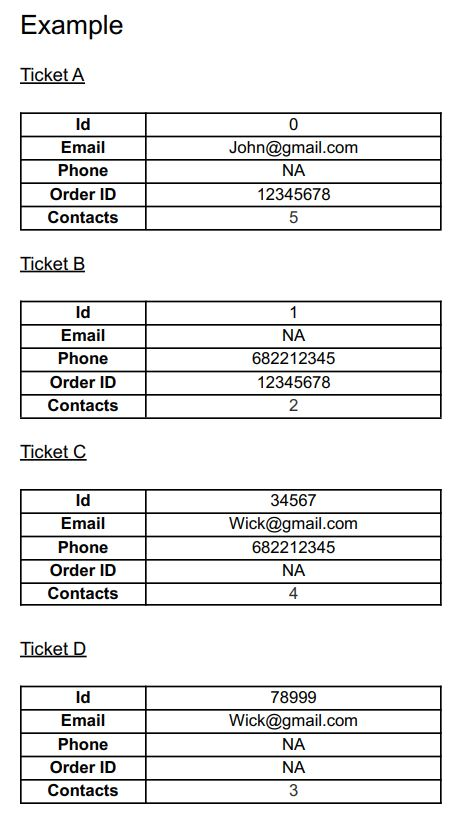

Explanation 

1.  Each of these tickets are related either directly or indirectly through Email, Phone or Order ID,
therefore each ticket belongs to the same user.
    1. Ticket A and B are linked through Order ID
    2. Tickets B and C are linked through Phone
    3. Tickets C and D are linked through Email
    4. Tickets A and D are indirectly linked through tickets A > B > C > D

In this example, this user has a total of 14 contacts. The ticket_trace/contact pair for this user would be 0-1-34567-78999, 14.




In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
%%time

# load data
df = pd.read_json("contacts.json")

# initial all_id
all_id = df["Id"].copy()

# save up memory by replace NA with np.nan
df = df.replace("", np.nan)

# get all duplicate records
dup_email = df.groupby("Email").agg({"Contacts":"sum", "Id":list})
dup_phone = df.groupby("Phone").agg({"Contacts":"sum", "Id":list})
dup_orderid = df.groupby("OrderId").agg({"Contacts":"sum", "Id":list})

dup_email = dup_email.reset_index()
dup_email = dup_email.rename({'Id':'linked_by_email'},axis=1)

dup_phone = dup_phone.reset_index()
dup_phone = dup_phone.rename({'Id':'linked_by_phone'},axis=1)

dup_orderid = dup_orderid.reset_index()
dup_orderid = dup_orderid.rename({'Id':'linked_by_orderid'},axis=1)

# merge
df = df.drop(['Contacts'],axis=1).merge(dup_email.drop(['Contacts'],axis=1), on='Email', how='left')\
.merge(dup_phone.drop(['Contacts'],axis=1), on='Phone', how='left')\
.merge(dup_orderid.drop(['Contacts'],axis=1), on='OrderId', how='left')

# preprocess
df['linked_by_email'] = df['linked_by_email'].apply(lambda d: d if isinstance(d, list) else [])
df['linked_by_phone'] = df['linked_by_phone'].apply(lambda d: d if isinstance(d, list) else [])
df['linked_by_orderid'] = df['linked_by_orderid'].apply(lambda d: d if isinstance(d, list) else [])

df['set_id'] = df['linked_by_email'] + df['linked_by_phone'] + df['linked_by_orderid']
df['set_id'] = df['set_id'].apply(lambda x: set(x))
df['len_set_id'] = df['set_id'].apply(lambda x: len(x))

CPU times: user 23.9 s, sys: 517 ms, total: 24.5 s
Wall time: 24.5 s


In [3]:
%%time

search_spaces = df['set_id'].tolist()
d = {i : set_id for i, set_id in zip(df['Id'],df['set_id'])}

# running time ~ 2.31 sec
for id, ids in d.items():
    for _id in list(ids):
        d[id] |= d[_id]

CPU times: user 1.26 s, sys: 45 ms, total: 1.3 s
Wall time: 1.31 s


In [4]:
%%time

# submission
df = pd.read_json("contacts.json")
df['ticket_trace'] = df['Id'].apply(lambda x : d[x])
df['ticket_trace'] = df['ticket_trace'].apply(lambda x : "-".join([str(e) for e in sorted(list(x))]))
gb = df.groupby(['ticket_trace'],as_index=False).agg({"Contacts":'sum'})
res = df[['Id', 'ticket_trace']].merge(gb, on='ticket_trace', how='left')
res['ticket_trace/contact'] = res['ticket_trace'] + ', ' + res['Contacts'].astype(str)
res = res[['Id','ticket_trace/contact']].rename({"Id":"ticket_id"},axis=1)
res.to_csv(f'{datetime.now().strftime("%Y%m%d_%H%M%s")}_submission.csv', index=False)
res.head(10)

CPU times: user 5.56 s, sys: 177 ms, total: 5.73 s
Wall time: 5.74 s
